In [3]:
from classification import *
from trading import *
import numpy as np
import pandas as pd
import sqlite3
from sklearn.metrics import confusion_matrix
import plotly.express as px

## Reading the Event Data and the Stock Data

In [4]:
# Connect to the SQLite database
conn = sqlite3.connect('final_data.db')

# Replace 'your_table' with the actual table name and 'conn' with your database connection
query = 'SELECT * FROM features_complete'

# Use the pandas read_sql function to read the data into a DataFrame
events_df = pd.read_sql(query, conn)

# Close the database connection
conn.close()

# Now, you can work with the DataFrame 'df'
events_df['date'] = pd.to_datetime(events_df['date'])
events_df = events_df.sort_values(by='date')
stock_df = pd.read_csv('stock_data.csv', header=[0, 1], index_col=0, parse_dates=True)

## Preparing the Return Classes and Train and Test Sets

In [41]:
target_col = 'NCAR'
exclude_cols = ['20_day_pct_ret', 'ticker', 'stage', 'catalyst', 'quintiles', 'NCAR', 'disease', 'date']
test_size = 0.2
num_cuts = 5
dh = Data_Handler(events_df)
quintiles = dh.qcut_data(target_col, num_cuts)
dh.df['quintiles'] = quintiles
labels = [str(label) for label in quintiles.unique()].sort()
X_train, X_test, y_train, y_test = dh.train_test_split('quintiles', cols2exclude = exclude_cols, test_size=test_size)

## Exploratory Analysis

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

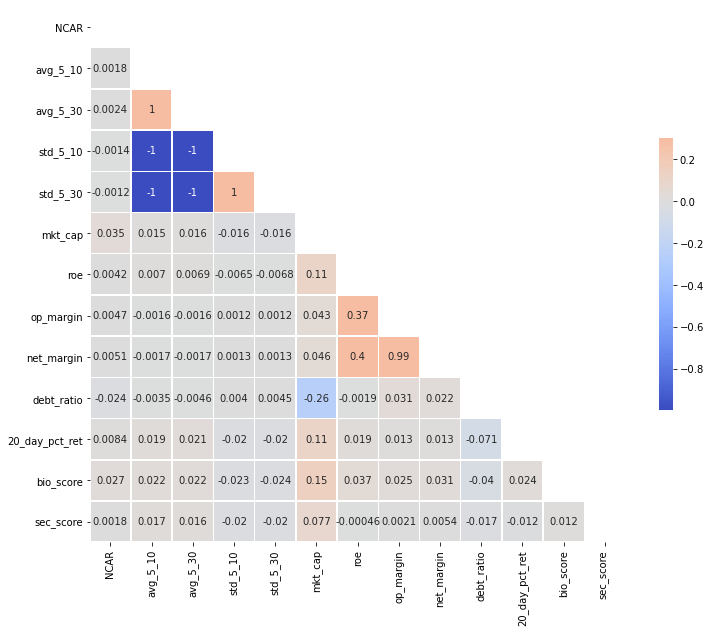

In [26]:
# Compute the correlation matrix
corr = events_df.iloc[:,5:-1].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap='coolwarm', vmax=.3, center=0,
            square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .5})

plt.show()

## Logistic Regression

In [42]:
# Create and fit the logistic regression model
model = LR()
model.train(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)
y_prob = model.predict_prob(X_test)

In [43]:
lr_fit_metrics = model.results.calculate_metrics(y_test, y_prob, y_pred, "Logistic Regression")
model.results.print_confusion_matrix(y_test, y_pred, labels)
model.results.plot_roc_curve(y_test, y_prob, "Logistic Regression")
print(lr_fit_metrics)

/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Model        Logistic Regression
AUC                     0.601101
Accuracy                0.137255
Precision               0.027451
Recall                       0.2
F1 Score                0.048276
dtype: object


In [44]:
trading_data = events_df.loc[X_test.index].reset_index(drop=True)
trading_data['lr_preds'] = y_pred
trading_data['lr_signal'] = np.where(y_pred > 2, 1, np.where(y_pred < 2, -1, 0))
ts = Trading_Strategy()
lr_portfolio = ts.buy_short('lr_signal', trading_data, stock_df, 20)

In [45]:
px.line(np.array(lr_portfolio))

## XGBoost

In [46]:
# Create and fit the XGBoost model
model = GB()
model.train(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)
y_prob = model.predict_prob(X_test)

In [47]:
gb_fit_metrics = model.results.calculate_metrics(y_test, y_prob, y_pred, "XGBoost Classifier")
model.results.print_confusion_matrix(y_test, y_pred, labels)
model.results.plot_roc_curve(y_test, y_prob, "XGBoost Classifier")
print(gb_fit_metrics)

Model        XGBoost Classifier
AUC                    0.598885
Accuracy               0.320261
Precision              0.301023
Recall                 0.298463
F1 Score               0.294532
dtype: object


In [48]:
trading_data['gb_preds'] = y_pred
trading_data['gb_signal'] = np.where(y_pred > 2, 1, np.where(y_pred < 2, -1, 0))
ts = Trading_Strategy()
gb_portfolio = ts.buy_short('gb_signal', trading_data, stock_df, 20)

In [49]:
px.line(np.array(gb_portfolio))

## MLP Classifier

In [37]:
# Create and fit the Multi Layer Perceptron model
model = MLP()
model.train(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)
y_prob = model.predict_prob(X_test)

In [38]:
mlp_fit_metrics = model.results.calculate_metrics(y_test, y_prob, y_pred, "MLP Classifier")
model.results.print_confusion_matrix(y_test, y_pred, labels)
model.results.plot_roc_curve(y_test, y_prob, "MLP Classifier")
print(mlp_fit_metrics)

/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Model        MLP Classifier
AUC                     0.5
Accuracy           0.137255
Precision          0.027451
Recall                  0.2
F1 Score           0.048276
dtype: object


In [39]:
trading_data['mlp_preds'] = y_pred
trading_data['mlp_signal'] = np.where(y_pred > 2, 1, np.where(y_pred < 2, -1, 0))
ts = Trading_Strategy()
mlp_portfolio = ts.buy_short('mlp_signal', trading_data, stock_df, 20)

In [40]:
px.line(np.array(mlp_portfolio))